### Step 1: Reading and Understanding the Data

In [88]:
# Importing all required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import sqlite3
conn = sqlite3.connect('research.db')


###  Fetch all accounts

In [52]:
cur = conn.cursor()
cur.execute("select \"Id\", \"RecordType.Name\",\"Industry\",\"Business_Type__c\",\"Country__c\",\"Is_External__c\",\"ParentId\"from \"Account\" union \
select \"Id\", \"RecordType.Name\",\"Education\" as \"Industry\",\"Not for profit\" as \"Business_Type__c\",\"Australia\" as \"Country__c\", \
\"Is_External__c\",\"ParentId\" from \"Account_internal\"")
accounts_all = cur.fetchall()
accounts_all= pd.DataFrame(accounts_all)
accounts_all.columns= ['AccountID', 'AccountType','Industry','BusinessType','Country','Internal_External','ParentAccount']
accounts_all.loc[accounts_all['AccountType'] == 'University Department', 'Industry'] = 'Education'  
accounts_all.loc[accounts_all['AccountType'] == 'University Department', 'BusinessType'] = 'Not for profit'  
accounts_all.loc[accounts_all['AccountType'] == 'University Department', 'Country'] = 'Australia' 
accounts_all["f_parent"]=accounts_all['ParentAccount'].notnull().astype(int)
accounts_all=accounts_all.drop(["ParentAccount"],axis=1)

In [124]:
cur.execute("select * from \"Opportunities\"")
Opportunity_raw = cur.fetchall()
Opportunity_raw= pd.DataFrame(Opportunity_raw)
Opportunity_raw.columns= ['ID', 'outcome','status_reason','init_OppType','Opptype','Supppoted', 
                          'createDate','est_closeDate','act_closeDate', 'est_amt','est_proj','act_amt',
                          'act_proj','bd_cluster','bd_div','aud_type','course_type','accountId',
                          'cust_contact','lead_aca_contact','lead_faculty','lead_school','lead_dep','supp_1'
                          ,'supp_2','ownerid','parent_opp'
                         ]
Opportunity_raw.loc[Opportunity_raw["lead_faculty"].isnull(),"lead_faculty"] = "Missing Faculty"
Opportunity_raw.loc[Opportunity_raw["act_amt"].isnull(),"act_amt"] = Opportunity_raw["est_amt"] 
Opportunity_raw.loc[Opportunity_raw["act_amt"].isnull(),"act_amt"] = 0
Opportunity_raw.loc[Opportunity_raw["act_proj"].isnull(),"act_proj"] = Opportunity_raw["est_proj"]
Opportunity_raw.loc[Opportunity_raw["act_proj"].isnull(),"act_proj"] = 0
Opportunity_raw.loc[Opportunity_raw["act_closeDate"].isnull(),"act_closeDate"] = Opportunity_raw["est_closeDate"]
Opportunity_raw['createDate'] = Opportunity_raw['createDate'].str[:10]
Opportunity_raw['createDate'] = pd.to_datetime(Opportunity_raw['createDate'])
Opportunity_raw['act_closeDate'] = pd.to_datetime(Opportunity_raw['act_closeDate'])
Opportunity_raw['closeDate_month'] = Opportunity_raw['act_closeDate'].dt.month
Opportunity_raw['createDate_month'] = Opportunity_raw['createDate'].dt.month
Opportunity_raw['closeDate_year'] = Opportunity_raw['act_closeDate'].dt.year
Opportunity_raw['createDate_year'] = Opportunity_raw['createDate'].dt.year
Opportunity_raw['days_diff']=(Opportunity_raw['act_closeDate']-Opportunity_raw['createDate']).dt.days
Opportunity_raw["f_parent_opp"]=Opportunity_raw['parent_opp'].notnull().astype(int)
Opportunity_raw_after=Opportunity_raw[['outcome','Opptype','Supppoted', 
                          'days_diff','closeDate_month','createDate_month','closeDate_year','createDate_year','act_amt',
                          'act_proj','accountId',
                          'lead_faculty','f_parent_opp']]


In [134]:
merged=Opportunity_raw_after.merge(accounts_all, left_on='accountId', right_on='AccountID',how='left')
merged=merged.drop(["accountId","AccountID"],axis=1)
merged_data=merged[(merged.outcome == 'Closed Lost')|(merged.outcome =='Closed Won')]

In [136]:
merged_data.to_csv('merged_data.csv',index=False)

In [144]:
print(len(merged_data))
merged_data=merged_data[~merged_data.AccountType.isna()]
merged_data=merged_data[~merged_data.BusinessType.isna()]
print(len(merged_data))
merged_data.to_csv('merged_data_final.csv',index=False)

X = merged_data.iloc[:, 1:].values
y = merged_data.iloc[:, 0].values


5689
5689


In [145]:
from sklearn.preprocessing import LabelEncoder

labelencoder_X = LabelEncoder()
X[:,0] = labelencoder_X.fit_transform(X[:,0])
X[:,1] = labelencoder_X.fit_transform(X[:,1])
X[:,9] = labelencoder_X.fit_transform(X[:,9])
X[:,11] = labelencoder_X.fit_transform(X[:,11])
X[:,12] = labelencoder_X.fit_transform(X[:,12])
X[:,13] = labelencoder_X.fit_transform(X[:,13])
X[:,14] = labelencoder_X.fit_transform(X[:,14])
X[:,15] = labelencoder_X.fit_transform(X[:,15])

labelencoder_y = LabelEncoder()
y = labelencoder_y.fit_transform(y)


In [157]:
from sklearn.model_selection import train_test_split
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
# summarize
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (4551, 17) (4551,)
Test (1138, 17) (1138,)


In [158]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(logreg.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(logreg.score(X_test, y_test)))

Accuracy of Logistic regression classifier on training set: 0.65
Accuracy of Logistic regression classifier on test set: 0.66


In [159]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier().fit(X_train, y_train)
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on training set: 1.00
Accuracy of Decision Tree classifier on test set: 0.85


In [160]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.87
Accuracy of K-NN classifier on test set: 0.85


In [161]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
print('Accuracy of LDA classifier on training set: {:.2f}'
     .format(lda.score(X_train, y_train)))
print('Accuracy of LDA classifier on test set: {:.2f}'
     .format(lda.score(X_test, y_test)))

Accuracy of LDA classifier on training set: 0.68
Accuracy of LDA classifier on test set: 0.69


In [162]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
print('Accuracy of GNB classifier on training set: {:.2f}'
     .format(gnb.score(X_train, y_train)))
print('Accuracy of GNB classifier on test set: {:.2f}'
     .format(gnb.score(X_test, y_test)))

Accuracy of GNB classifier on training set: 0.64
Accuracy of GNB classifier on test set: 0.66


In [163]:
from sklearn.svm import SVC
svm = SVC()
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(X_test, y_test)))

Accuracy of SVM classifier on training set: 1.00
Accuracy of SVM classifier on test set: 0.68


([<matplotlib.axis.XTick at 0x1cdb4932e10>,
 <a list of 5 Text xticklabel objects>)

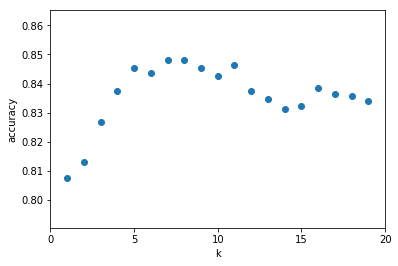

In [164]:
k_range = range(1, 20)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20])